### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 27 апреля 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 27 апреля, -4 балла после 08:30 4 мая, -6 баллов после 08:30 11 мая, -8 баллов после 08:30 18 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

from collections import defaultdict

Надо реализовать:

__find_threshold

__fit_node

get_feature_importance

In [2]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        {'misclass', 'gini', 'entropy'}
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.classes = np.nan
        
        self.criterion = criterion
        if criterion == 'misclass':
            self.__Q = self.__misclass
            self.G = self.__misclass_G
        elif criterion == 'gini':
            self.__Q = self.__gini
            self.G = self.__gini_G
        elif criterion == 'entropy':
            self.__Q = self.__entropy
            self.G = self.__entropy_G
            
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]
    
    def _log2(self, a, b):
        b = np.repeat(b, a.shape[0])
        div = np.divide(a, b, where=b!=0)
        return np.where(div != 0, np.log2(div), 0)

    def __gini(self, f0, f1, f2, N0, N1, N2):
        return np.sum(np.square(f0)) / N0 ** 2 - (np.sum(np.square(f1)) / N1 + np.sum(np.square(f2)) / N2) / N0

    def __entropy(self, f0, f1, f2, N0, N1, N2):
        return -(np.sum(f1 * self._log2(f1, N1)) + np.sum(f2 * self._log2(f2, N2))) / N0
    
    def __misclass(self, f0, f1, f2, N0, N1, N2):
        return -(np.max(f1) + np.max(f2) - np.max(f0)) / N0

    def __process_threshold(self, ind, x, y):
        y1, y2 = y[:ind], y[ind:]

        if y1.shape[0] < self.min_samples_split or y2.shape[0] < self.min_samples_split:
            return np.nan
        f1 = np.bincount(y1, minlength=self.num_class)
        f2 = np.bincount(y2, minlength=self.num_class)
        f0 = np.add(f1, f2)
        N1, N2 = ind, y.shape[0] - ind
        N0 = N1 + N2

        return self.__Q(f0, f1, f2, N0, N1, N2)

    def __col_threshold(self, x, y):
        sorted_x_ind = x.argsort()
        x_s, y_s = x[sorted_x_ind], y[sorted_x_ind]
        # find indices of changes
        change_ind0 = np.where(y_s[:-1] != y_s[1:])[0]
        change_ind1 = np.where(y_s[:-1] != y_s[1:])[0] + 1
        change_ind = np.concatenate((change_ind0, change_ind1), axis=None)
        if change_ind.shape[0] == 0:
            return [np.nan, np.nan]
        # Q for each index
        qs = np.zeros(change_ind.shape[0])
        k = 0
        for i in change_ind:
            qs[k] = self.__process_threshold(i, x_s, y_s)
            k+=1
        if np.isnan(qs).any():
            return [np.nan, np.nan]
        best_q_ind = qs.argmin()
        best_change_ind = change_ind[best_q_ind]
        if best_change_ind != 0:
            best_threshold = (x_s[best_change_ind] + x_s[best_change_ind-1]) / 2
        else:
            best_threshold = (x_s[best_change_ind+1] + x_s[best_change_ind]) / 2
        best_qs = qs[best_q_ind]
        return [best_threshold, best_qs]
    
    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        min_q = 1000
        opt_feat = np.nan
        threshold = np.nan
        for i in range(x.shape[1]):
            threshold_tmp, tmp_q = self.__col_threshold(x[:,i], y)
            if tmp_q < min_q:
                min_q = tmp_q
                threshold = threshold_tmp
                opt_feat = i
        return opt_feat, threshold

    
    def __misclass_G(self, y):
        return 1 - np.max(np.divide(np.bincount(y, minlength=self.num_class), y.shape[0]))
    
    def __gini_G(self, y):
        return 1 - np.sum(np.square(np.divide(np.bincount(y, minlength=self.num_class), y.shape[0])))
    
    def __entropy_G(self, y):
        p = np.bincount(y, minlength=self.num_class)
        return -np.sum(p * self._log2(p, y.shape[0]))

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        #print("NODE ID", node_id)
        classes_count = np.bincount(y, minlength=self.num_class)
        node_data = (self.LEAF_TYPE, np.argmax(classes_count), np.divide(classes_count, classes_count.shape[0]))
        
        if (self.max_depth is not None and depth >= self.max_depth) \
        or (self.min_samples_split is not None and y.shape[0] <= self.min_samples_split):
            self.tree[node_id] = node_data
            return
        feature_id, threshold = self.__find_threshold(x, y)
        if np.isnan(feature_id):
            self.tree[node_id] = node_data
            return
        x_l, x_r, y_l, y_r  = self.__div_samples(x, y, feature_id, threshold)
        if y_l.shape[0] == 0 or y_r.shape[0] == 0 or x_r.size==0 or x_l.size==0:
            self.tree[node_id] = node_data
            return
        
        self.feature_importances_[feature_id] += \
            self.G(y)-(y_l.shape[0]*self.G(y_l) + y_r.shape[0]*self.G(y_r))/y.shape[0]
        self.tree[node_id] = (self.NON_LEAF_TYPE, feature_id, threshold)
        self.__fit_node(x_l, y_l, 2 * node_id + 1, depth + 1)
        self.__fit_node(x_r, y_r, 2 * node_id + 2, depth + 1)
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.classes = np.unique(y)
        self.num_class = self.classes.size
        self.feature_importances_ = np.zeros(x.shape[1])
        self.__fit_node(x, y, 0, 0)
        self.feature_importances_ = np.divide(self.feature_importances_, np.sum(self.feature_importances_))

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance():
        """
        Возвращает важность признаков
        """
        return self.feature_importances_

check gini

In [3]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion='gini')
clf = DecisionTreeClassifier(min_samples_split=2, criterion='gini')

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target,
                                                   random_state=42)

In [5]:
%%time 
clf.fit(X_train, y_train)

CPU times: user 1.39 ms, sys: 907 µs, total: 2.3 ms
Wall time: 1.35 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [6]:
%%time 
my_clf.fit(X_train, y_train)

CPU times: user 64 ms, sys: 3.49 ms, total: 67.5 ms
Wall time: 65.1 ms


In [7]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


check entropy

In [8]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion='entropy')
clf = DecisionTreeClassifier(min_samples_split=2, criterion='entropy')

In [9]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target,
                                                   random_state=42)

In [10]:
%%time 
clf.fit(X_train, y_train)

CPU times: user 1.6 ms, sys: 957 µs, total: 2.56 ms
Wall time: 1.32 ms


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [11]:
%%time 
my_clf.fit(X_train, y_train)

CPU times: user 163 ms, sys: 4.32 ms, total: 167 ms
Wall time: 168 ms


/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log2


In [12]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

1.0
1.0


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [13]:
df = pd.read_csv('/Users/daria/Downloads/Speed Dating Data.csv', encoding='latin1')

In [14]:
df = df.iloc[:, :97]
df = df.drop(['id', 'idg', 'condtn', 'field', 'undergra', 'from', 'zipcode', 
              'round', 'position', 'positin1', 'order', 'partner',
              'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb',
              'pf_o_sha', 'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 
              'like_o', 'prob_o', 'met_o', 'sports', 'tvsports', 'exercise', 'dining', 
              'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv','theater', 
              'movies', 'concerts', 'music', 'shopping', 'yoga', 'career', 'expnum'], axis=1)
df.drop_duplicates('iid')
df = df.dropna(subset=['age'])
df = df.dropna(subset=['imprelig', 'imprace'])
df = df.dropna(subset=['date'])
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(0)
pd.get_dummies(df, columns=['field_cd'], prefix='field_cd', prefix_sep='=')
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float).fillna(-999)
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float).fillna(-999)
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float).fillna(-999)
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(0)
features = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1',
        'amb1_1', 'shar1_1']
tmp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, features]
tmp.loc[:, 'totalsum'] = tmp.iloc[:, 2:].sum(axis=1)
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1',
          'shar1_1']].sum(axis=1)
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1',
           'shar1_1']] = (df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1',
                                     'fun1_1', 'amb1_1', 'shar1_1']].T /
                          df.loc[:, 'temp_totalsum'].T).T * 100
features = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1',
        'amb2_1', 'shar2_1']
tmp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, features]
tmp.loc[:, 'totalsum'] = tmp.iloc[:, 2:].sum(axis=1)
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1',
                                        'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1',
           'shar2_1']] = (df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1',
                                     'fun2_1', 'amb2_1', 'shar2_1']].T /
                          df.loc[:, 'temp_totalsum'].T).T * 100
features = ['attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1', 'amb4_1', 'shar4_1']
df = df.drop(features, axis=1)
features = ['attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1']
df = df.drop(features, axis=1)
df = df.drop(['wave'], axis=1)
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid']) \
            .drop(['gender'], axis=1).dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid']) \
            .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1).dropna()
df_female.columns = df_female.columns + '_f'
df_female = df_female.drop(['pid_f'], axis=1)
df_pair = df_male.join(df_female.set_index('iid_f'), on='pid', how='inner')
df_pair = df_pair.drop(['iid', 'pid'], axis=1)
X = df_pair.iloc[:, 1:].values
y = df_pair.iloc[:, 0].values

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [16]:
from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold

In [17]:
my_clf = MyDecisionTreeClassifier()
clf = DecisionTreeClassifier()

Сначала посмотрим на классификатор из sklearn

In [18]:
best_sk = GridSearchCV(clf,{'criterion':['gini', 'entropy']}, cv=5)
best_sk.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,


In [19]:
param_range = [5, 10, 30, 50, 60, 100, 150, 200]
train_scores, test_scores = validation_curve(
    clf, X_train, y_train, param_name="max_depth", param_range=param_range,
    scoring="accuracy", n_jobs=-1, cv=5)

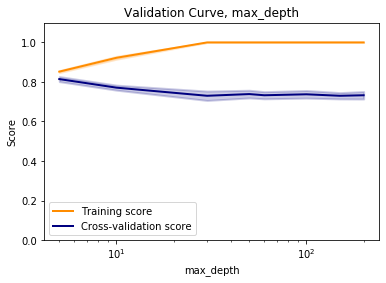

In [20]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve, max_depth")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [21]:
param_range = [2, 3, 4, 5, 10, 20, 50, 100, 200]
train_scores, test_scores = validation_curve(
    clf, X_train, y_train, param_name="min_samples_split", param_range=param_range,
    scoring="accuracy", n_jobs=-1, cv=5)

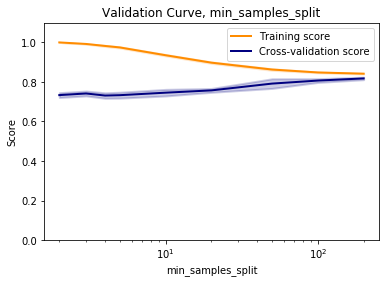

In [22]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve, min_samples_split")
plt.xlabel("min_samples_split")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Теперь посмотрим на мой классификатор

In [23]:
max_score = -np.inf
for criterion in ['misclass', 'gini', 'entropy']:
    print(criterion, 'calculated')
    my_clf = MyDecisionTreeClassifier(criterion=criterion)
    my_clf.fit(X_train, y_train)
    score = accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
    if score >= max_score:
        max_score, best_criterion = score, criterion
print('Best criterion:', best_criterion)

misclass calculated


/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: invalid value encountered in true_divide


gini calculated
entropy calculated


/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log2


Best criterion: entropy


In [24]:
param_range = [5, 10, 30, 50, 60, 100, 150, 200]
test_scores = []
train_scores = [] 
for max_depth in param_range:
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    train_scores_tmp = []
    for train_index, test_index in kf.split(X_train):
        X_train_tmp, X_test_tmp = X_train[train_index], X_train[test_index]
        y_train_tmp, y_test_tmp = y_train[train_index], y_train[test_index]
        my_clf = MyDecisionTreeClassifier(criterion='entropy', max_depth = max_depth)
        my_clf.fit(X_train_tmp, y_train_tmp)
        train_scores_tmp.append(accuracy_score(y_pred=my_clf.predict(X_test_tmp), y_true=y_test_tmp))
    train_scores.append(train_scores_tmp)
    my_clf = MyDecisionTreeClassifier(criterion='entropy', max_depth = max_depth)
    my_clf.fit(X_train, y_train)
    test_scores.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))
    print(f'Done for {max_depth}')

/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log2


Done for 5
Done for 10
Done for 30
Done for 50
Done for 60
Done for 100
Done for 150
Done for 200


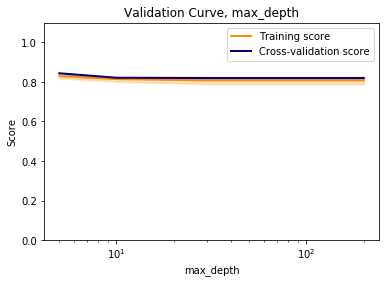

In [25]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = test_scores
test_scores_std = np.zeros(len(test_scores))

plt.title("Validation Curve, max_depth")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Тут всё как-то равномерно печально

In [26]:
param_range = [2, 3, 4, 5, 10, 20, 50, 100, 200]
test_scores = []
train_scores = [] 
for min_samples_split in param_range:
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    train_scores_tmp = []
    for train_index, test_index in kf.split(X_train):
        X_train_tmp, X_test_tmp = X_train[train_index], X_train[test_index]
        y_train_tmp, y_test_tmp = y_train[train_index], y_train[test_index]
        my_clf = MyDecisionTreeClassifier(criterion='entropy', min_samples_split = min_samples_split)
        my_clf.fit(X_train_tmp, y_train_tmp)
        train_scores_tmp.append(accuracy_score(y_pred=my_clf.predict(X_test_tmp), y_true=y_test_tmp))
    train_scores.append(train_scores_tmp)
    my_clf = MyDecisionTreeClassifier(criterion='entropy', max_depth = max_depth)
    my_clf.fit(X_train, y_train)
    test_scores.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))
    print(f'Done for {min_samples_split}')

/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log2


Done for 2
Done for 3
Done for 4


/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: invalid value encountered in true_divide


Done for 5
Done for 10
Done for 20
Done for 50
Done for 100
Done for 200


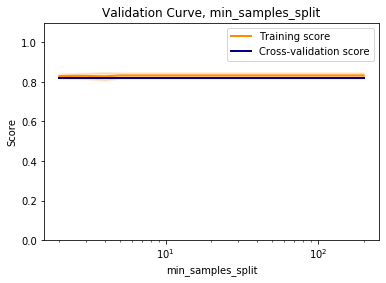

In [27]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = test_scores
test_scores_std = np.zeros(len(test_scores))

plt.title("Validation Curve, min_samples_split")
plt.xlabel("min_samples_split")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [28]:
my_clf = MyDecisionTreeClassifier(criterion='entropy')
clf = DecisionTreeClassifier(criterion='entropy')

In [29]:
%time clf.fit(X_train, y_train)

CPU times: user 44.1 ms, sys: 977 µs, total: 45.1 ms
Wall time: 44.2 ms


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [30]:
%time my_clf.fit(X_train, y_train)

/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log2


CPU times: user 16.7 s, sys: 71.2 ms, total: 16.8 s
Wall time: 17 s


In [31]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

0.7689393939393939

In [32]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.843939393939394

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [33]:
my_clf = MyDecisionTreeClassifier(criterion='entropy')
my_clf.fit(X_train, y_train)
print('accuracy:', accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log2


accuracy: 0.843939393939394


In [34]:
feat = df_pair.iloc[:, 1:].columns

In [35]:
feat[my_clf.feature_importances_ > 0]

Index(['age', 'imprace', 'date', 'intel2_1', 'fun2_1', 'amb2_1', 'fun3_1',
       'goal_f', 'fun1_1_f', 'shar1_1_f', 'attr2_1_f', 'fun2_1_f', 'attr3_1_f',
       'sinc3_1_f'],
      dtype='object')

In [36]:
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train, y_train)
print('accuracy:', accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))

accuracy: 0.7568181818181818


Попробуем обучиться только на этих признаках

Отобранные моим классификатором (14 штук) - незначительно, но хуже

In [37]:
X_train_add = X_train[:,my_clf.feature_importances_ > 0]
X_test_add = X_test[:,my_clf.feature_importances_ > 0]

my_clf = MyDecisionTreeClassifier(criterion='entropy')
my_clf.fit(X_train_add, y_train)
print('accuracy:', accuracy_score(y_pred=my_clf.predict(X_test_add), y_true=y_test))

/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log2


accuracy: 0.8401515151515152


Отобранные sklearn-ом (13 штук) - получше моего, но хуже по сравнению с исходным результатом

In [38]:
X_train_add = X_train[:,clf.feature_importances_ > 0.02]
X_test_add = X_test[:,clf.feature_importances_ > 0.02]

my_clf = MyDecisionTreeClassifier(criterion='entropy')
my_clf.fit(X_train_add, y_train)
print('accuracy:', accuracy_score(y_pred=my_clf.predict(X_test_add), y_true=y_test))

/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log2


accuracy: 0.8378787878787879


Sklearn на признаках, отобранных моим классификатором. Немного лучше!!

In [39]:
my_clf = MyDecisionTreeClassifier(criterion='entropy')
clf = DecisionTreeClassifier(criterion='entropy')
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
X_train_add = X_train[:,my_clf.feature_importances_ > 0]
X_test_add = X_test[:,my_clf.feature_importances_ > 0]

clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train_add, y_train)
print('accuracy:', accuracy_score(y_pred=clf.predict(X_test_add), y_true=y_test))

/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log2


accuracy: 0.7568181818181818


Sklearn на отобранных самим собой признаках. Сработал хуже

In [40]:
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train, y_train)
X_train_add = X_train[:,clf.feature_importances_ > 0.02]
X_test_add = X_test[:,clf.feature_importances_ > 0.02]

clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train_add, y_train)
print('accuracy:', accuracy_score(y_pred=clf.predict(X_test_add), y_true=y_test))

accuracy: 0.7386363636363636


Confusion matrix, without normalization
[[952 162]
 [157  49]]


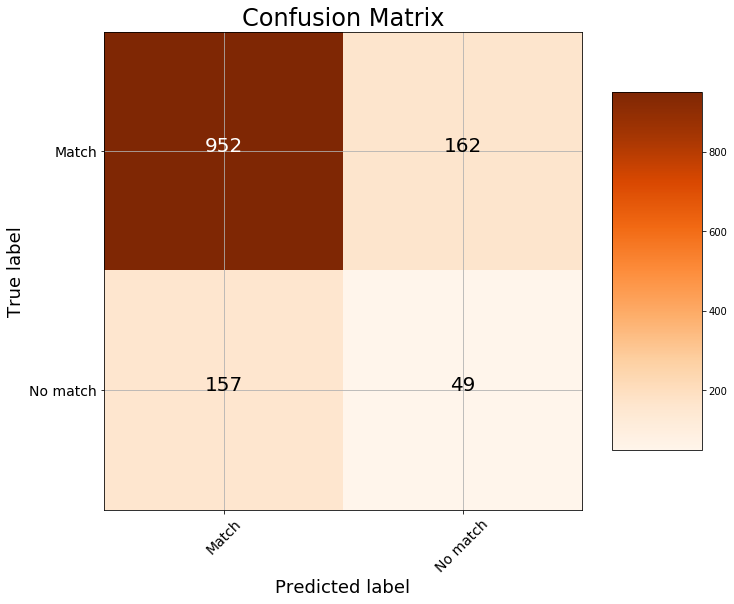

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes = ['Match', 'No match'],
                      title = 'Confusion Matrix')

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

